In [1]:
import os
import scanpy as sc
import scirpy as ir
import muon as mu
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt, cm as mpl_cm
import sys
from pathlib import Path

sys.path.insert(0, '/mnt/efs/hdiao/Projects/Tools')
import sc_tl

%matplotlib inline

sc.set_figure_params(frameon=False, figsize=(4, 4))
sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.9.3 pandas==1.5.2 scikit-learn==1.1.3 statsmodels==0.13.5 python-igraph==0.10.2 louvain==0.7.1 pynndescent==0.5.8


In [2]:
sp_name = "T"

###----- Setup output directories
wk_dir = "/mnt/efs/hdiao/Projects/BNT162b4_scRNA/1_scanpy_scirpy/1_%s"%sp_name
Path(wk_dir).mkdir(parents=True, exist_ok=True)

###----- Read feature reference and cite
sp_h5ad = "%s/%s.h5ad"%(wk_dir, sp_name)
adata = sc.read_h5ad(sp_h5ad)

sp_fltRS_h5ad = "%s/%s_fltRS_leiden.h5ad"%(wk_dir, sp_name)
adata_flt = sc.read_h5ad(sp_fltRS_h5ad)

###----- Separate out GEX data
gene_list = adata.var[adata.var['feature_types'] == 'Gene Expression'].index.tolist()
cite_list = adata.var[adata.var['feature_types'] == 'Antibody Capture'].index.tolist()

## TCR Quality Control

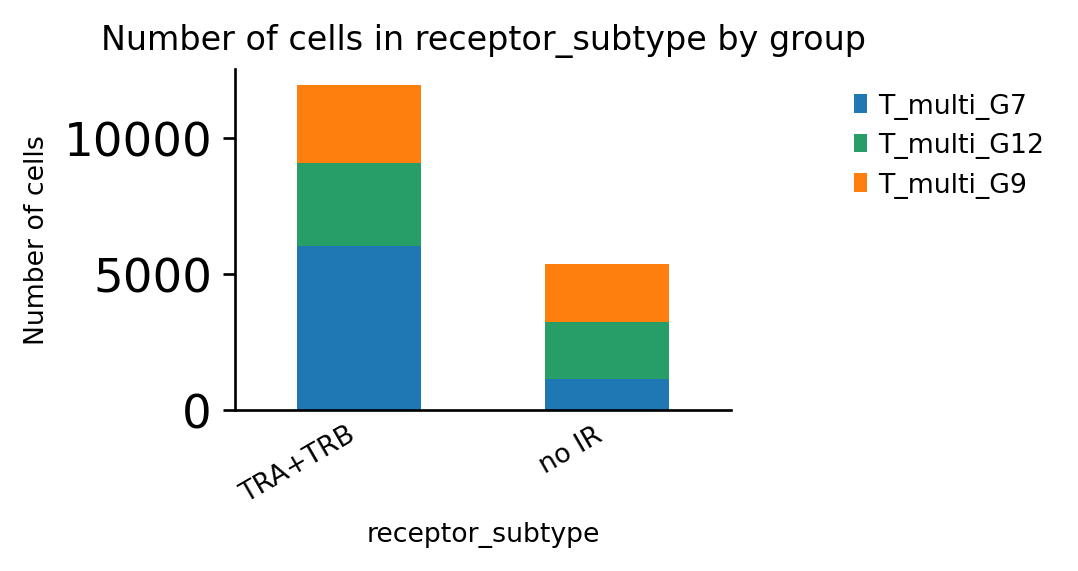

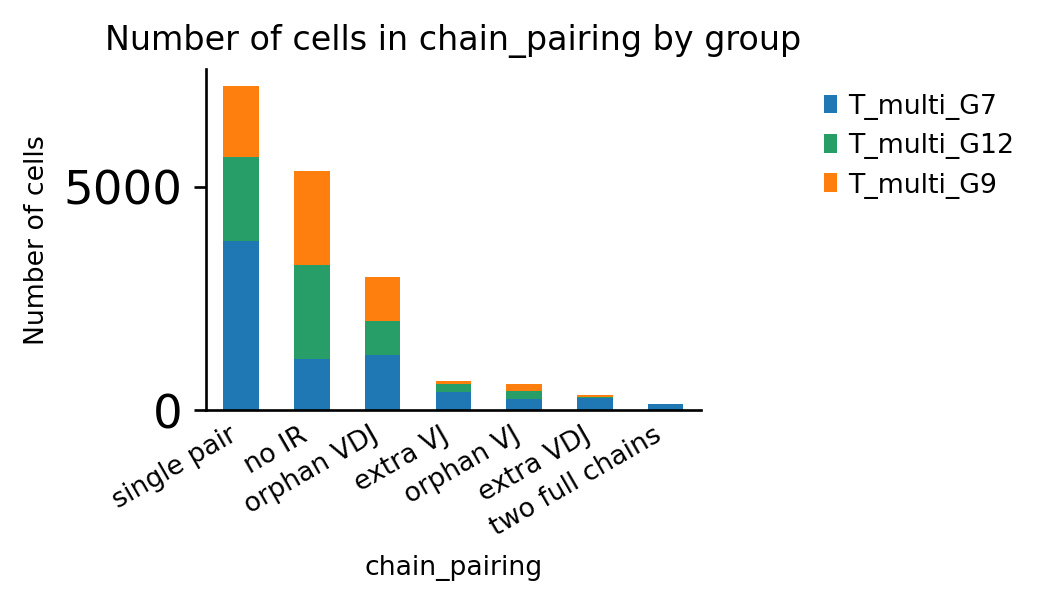

In [3]:
ir.tl.chain_qc(adata)

ax1 = ir.pl.group_abundance(adata, groupby='receptor_subtype', target_col='group')
ax2 = ir.pl.group_abundance(adata, groupby='chain_pairing', target_col='group')

## Compute CDR3 neighborhood graph and define clonotypes

  0%|          | 0/2036 [00:00<?, ?it/s]

<AxesSubplot: >

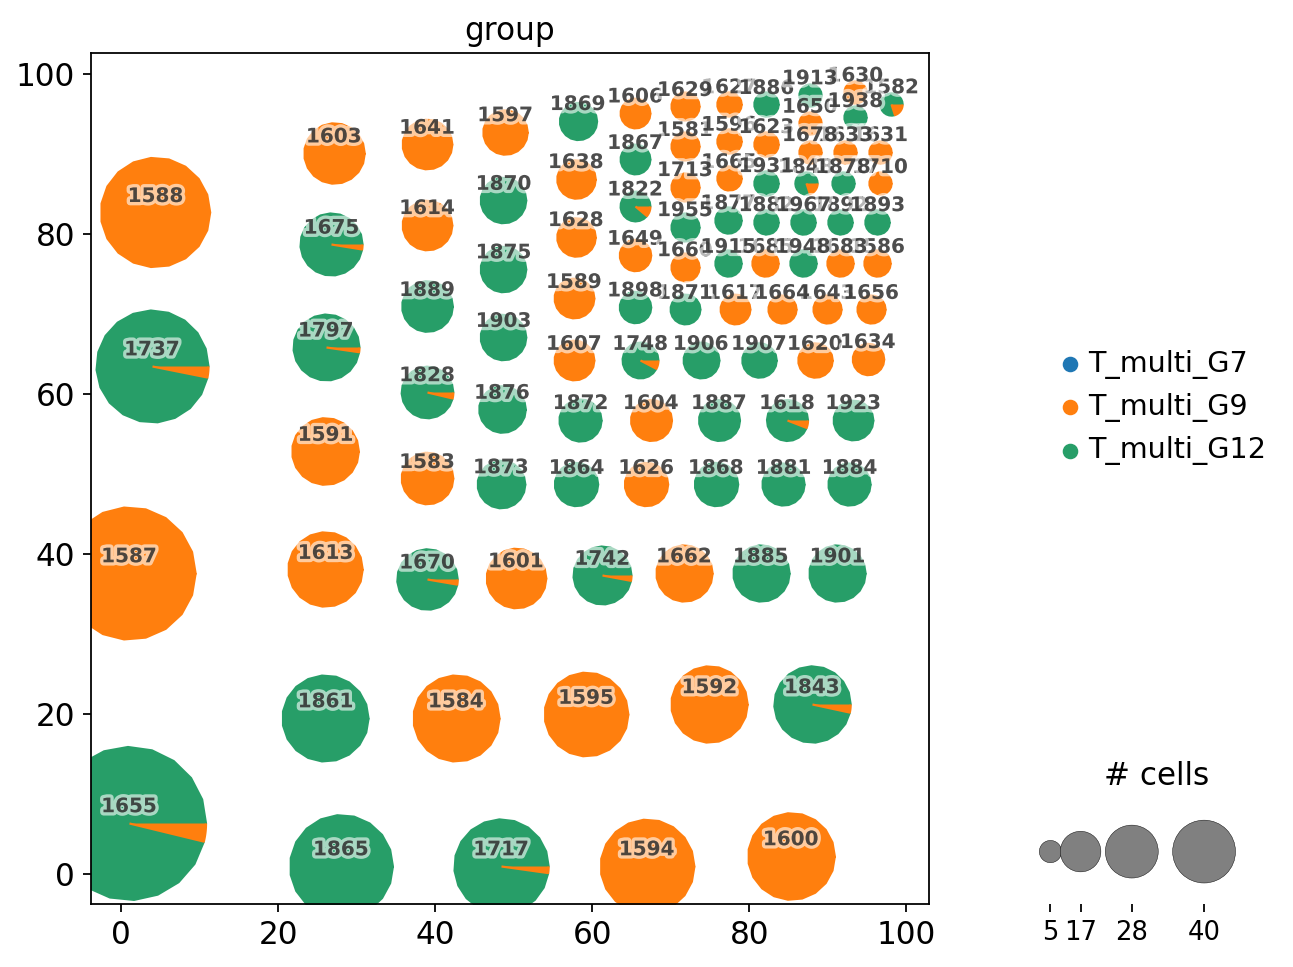

In [4]:
# using default parameters, `ir_dist` will compute nucleotide sequence identity
ir.pp.ir_dist(adata_flt)
ir.tl.define_clonotypes(adata_flt, receptor_arms="all", dual_ir="primary_only")
ir.tl.clonotype_network(adata_flt, min_cells=5)
ir.pl.clonotype_network(
    adata_flt, color="group", base_size=20, label_fontsize=9, panel_size=(7, 7)
)

## Re-compute CDR3 neighborhood graph and define clonotype clusters

  0%|          | 0/703 [00:00<?, ?it/s]

  0%|          | 0/780 [00:00<?, ?it/s]

  0%|          | 0/2023 [00:00<?, ?it/s]

<AxesSubplot: >

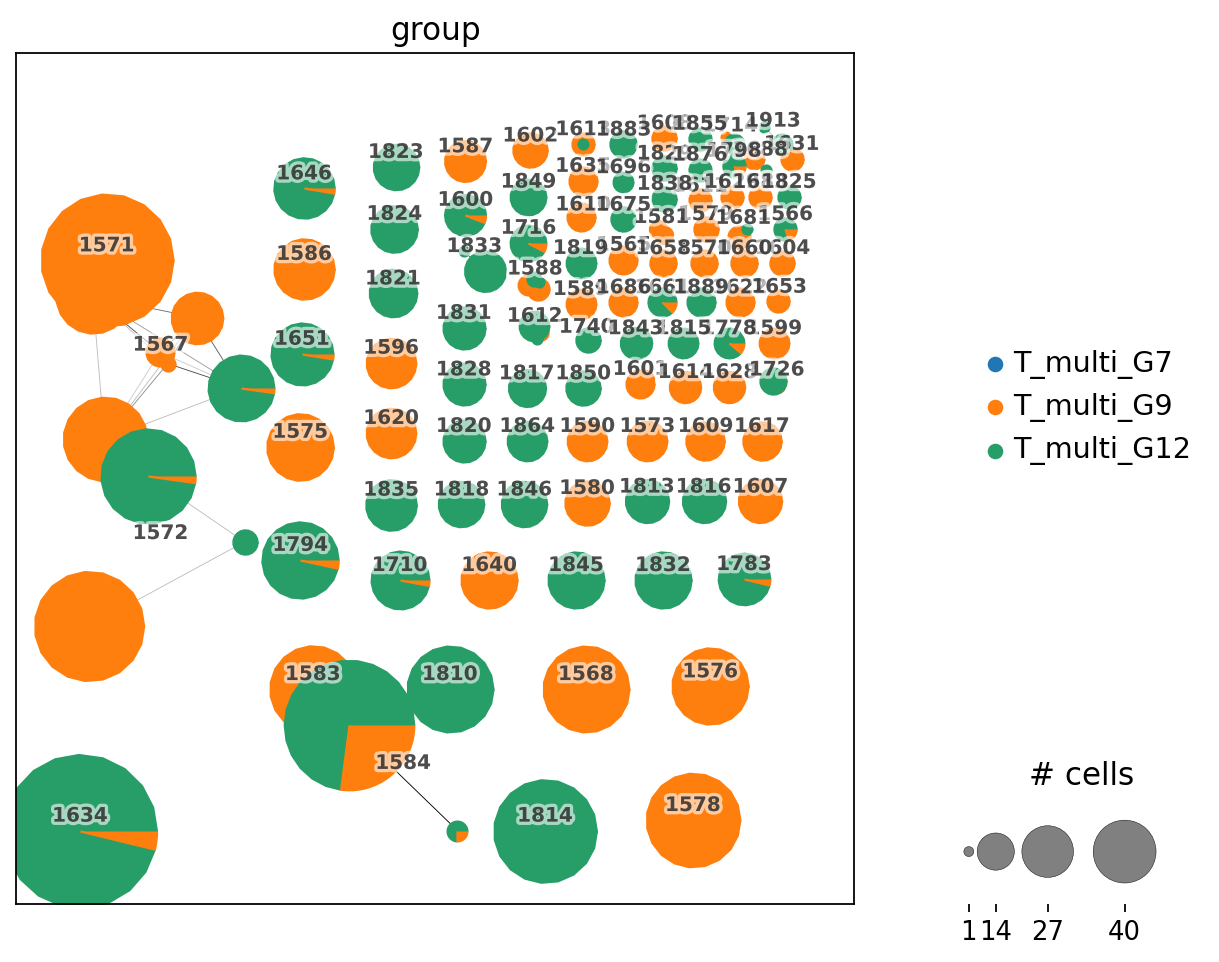

In [5]:
ir.pp.ir_dist(
    adata_flt,
    metric="alignment",
    sequence="aa",
    cutoff=15,
)

ir.tl.define_clonotype_clusters(
    adata_flt, sequence="aa", metric="alignment", receptor_arms="all", dual_ir="any"
)

ir.tl.clonotype_network(adata_flt, min_cells=5, sequence="aa", metric="alignment")

ir.pl.clonotype_network(
    adata_flt, color="group", label_fontsize=9, panel_size=(7, 7), base_size=20
)

<AxesSubplot: >

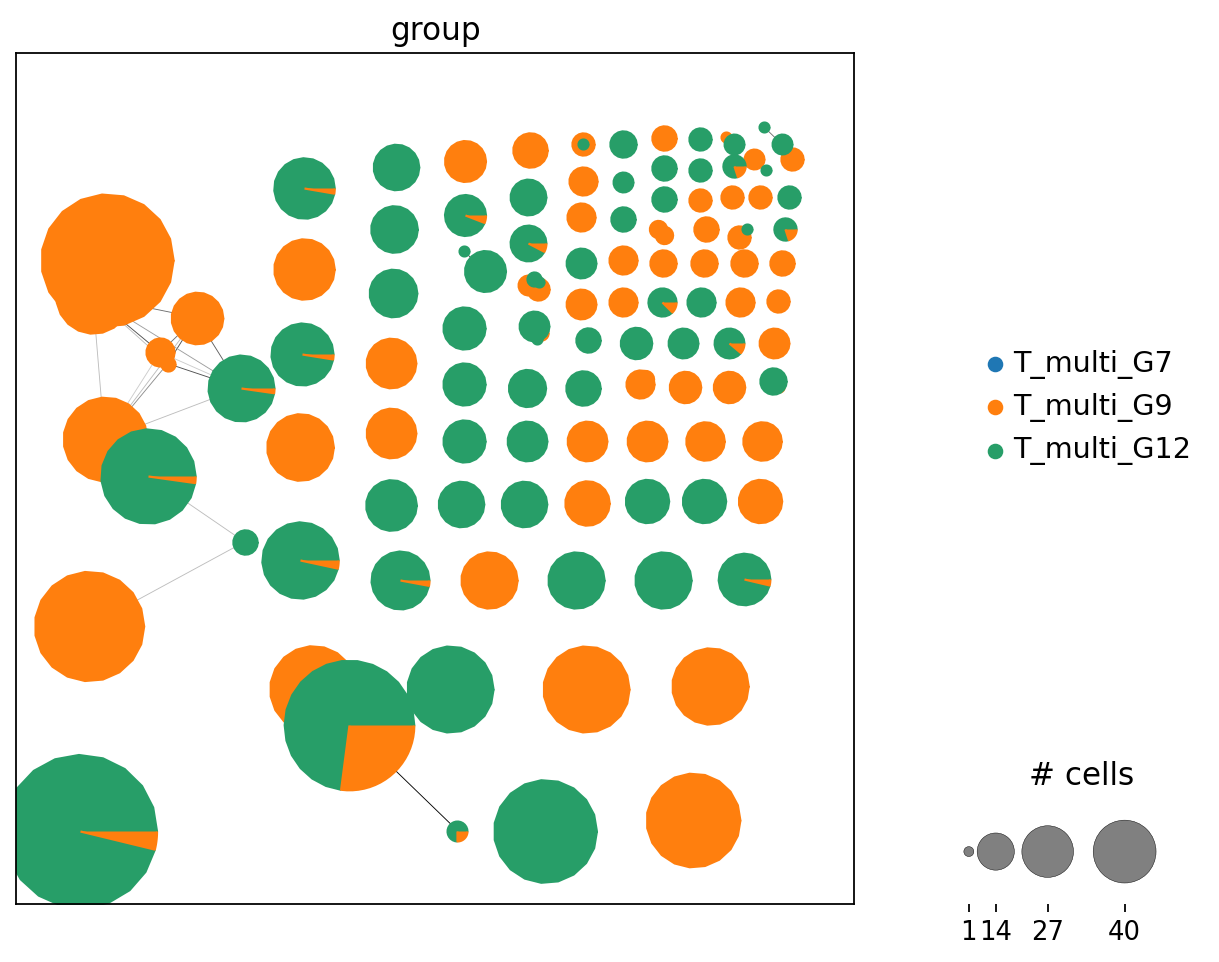

In [8]:
ir.pl.clonotype_network(
    adata_flt, color="group", show_labels=False, panel_size=(7, 7), base_size=20
)

## Including the V-gene in clonotype definition

In [10]:
ir.tl.define_clonotype_clusters(
    adata_flt,
    sequence="aa",
    metric="alignment",
    receptor_arms="all",
    dual_ir="any",
    same_v_gene=True,
    key_added="cc_aa_alignment_same_v",
)

# find clonotypes with more than one `clonotype_same_v`
ct_different_v = adata_flt.obs.groupby("cc_aa_alignment").apply(
    lambda x: x["cc_aa_alignment_same_v"].nunique() > 1
)
ct_different_v = ct_different_v[ct_different_v].index.values.tolist()

adata_flt.obs.loc[
    adata_flt.obs["cc_aa_alignment"].isin(ct_different_v),
    [
        "cc_aa_alignment",
        "cc_aa_alignment_same_v",
        "IR_VJ_1_v_call",
        "IR_VDJ_1_v_call",
    ],
].sort_values("cc_aa_alignment").drop_duplicates().reset_index(drop=True)

  0%|          | 0/2031 [00:00<?, ?it/s]

,cc_aa_alignment,cc_aa_alignment_same_v,IR_VJ_1_v_call,IR_VDJ_1_v_call
0,49,49,TRAV14-3,TRBV10
1,49,1324,TRAV9N-2,TRBV13-1
2,94,94,TRAV9-4,TRBV29
3,94,325,TRAV10,TRBV2
4,140,140,TRAV16N,TRBV13-3
...,...,...,...,...
92,1835,1871,TRAV16N,TRBV12-2+TRBV13-2
93,1850,1887,TRAV6D-3,TRBV12-2+TRBV13-2
94,1850,1907,TRAV6D-3,TRBV13-2
95,1913,1993,TRAV3-4,TRBV19


## Clonotype analysis

In [11]:
ir.tl.clonal_expansion(adata_flt)

<AxesSubplot: >

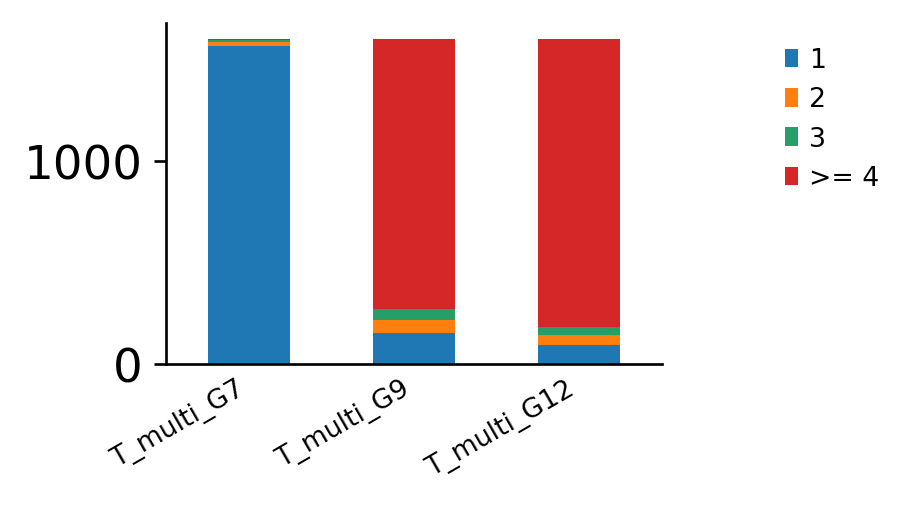

In [12]:
ir.pl.clonal_expansion(adata_flt, groupby="group", clip_at=4, normalize=False)

In [13]:
adata_flt.obs['expansion>=4'] = ['yes' if x >=4 else 'no' for x in adata_flt.obs['clone_id_size']]
clone_4_sum_df = adata_flt.obs.reset_index()[['index', 'group','expansion>=4']].\
                 groupby(['group','expansion>=4']).count().reset_index()
clone_4_sum_df = clone_4_sum_df.pivot(index='group', columns='expansion>=4', values='index')
clone_4_sum_df

expansion>=4,no,yes
group,,
T_multi_G7,1595,4
T_multi_G9,269,1330
T_multi_G12,180,1419


In [14]:
from scipy.stats import chisquare
print("G7 v.s. G9", chisquare(clone_4_sum_df.loc['T_multi_G7'], clone_4_sum_df.loc['T_multi_G9']))
print("G7 v.s. G12", chisquare(clone_4_sum_df.loc['T_multi_G7'], clone_4_sum_df.loc['T_multi_G12']))
print("G9 v.s. G12", chisquare(clone_4_sum_df.loc['T_multi_G9'], clone_4_sum_df.loc['T_multi_G12']))

G7 v.s. G9 Power_divergenceResult(statistic=7858.354037510132, pvalue=0.0)
G7 v.s. G12 Power_divergenceResult(statistic=12534.483497768382, pvalue=0.0)
G9 v.s. G12 Power_divergenceResult(statistic=49.58765562602772, pvalue=1.8970358613769692e-12)
